In [1]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 27.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 56.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 141.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 33.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 109.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 108.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 66.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 82.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 112.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
!pip install h5py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 69.6 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt

In [3]:
#dataloading and preprocessing
import h5py
with h5py.File('tactmat.h5', 'r') as dataset:
    samples = dataset['samples'][:]
    materials = dataset['materials'][:]
    materials = [m.decode('utf-8') for m in materials]

# Shuffle through classes
for i in range(samples.shape[0]):
    np.random.shuffle(samples[i])
    
train_size = int(0.8 * len(samples[0]))
train_samples = samples[:, :train_size-16, ...]
val_samples = samples[:, train_size-16:train_size, ...]
test_samples = samples[:, train_size:, ...]

# Flatten data
train_samples = train_samples.reshape((36*64, 1000, 16))  # (2880, 1000, 16)
test_samples = test_samples.reshape((36*20, 1000, 16))  # (720, 1000, 16)
val_samples = val_samples.reshape((36*16, 1000, 16))  # (720, 1000, 16)

# Create labels
train_labels = np.repeat(np.arange(36), 64)
test_labels = np.repeat(np.arange(36), 20)
val_labels = np.repeat(np.arange(36), 16)

# Shuffle the train one more time after flattening
indices = torch.randperm(len(train_samples))
train_samples = train_samples[indices]
train_labels = train_labels[indices]

# One-hot encoding not needed for pytorch CrossEntropyLoss
train_samples = torch.tensor(train_samples.reshape(2304, 1, 1000, 16), dtype=torch.float32)
val_samples = torch.tensor(val_samples.reshape(576, 1, 1000, 16), dtype=torch.float32)
test_samples = torch.tensor(test_samples.reshape(720, 1, 1000, 16), dtype=torch.float32)

train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)

In [4]:
# Model Definition
class MCTestTacNet(nn.Module):
    def __init__(self):
        super(MCTestTacNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(15, 5))
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(10, 1), stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(15, 5))
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=(10, 1), stride=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(15, 5))
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=(10, 1), stride=1)
        self.dropout = nn.Dropout(0.8)

        # Dummy forward pass to calculate the flattened size
        self.flattened_size = self._get_flatten_size()

        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 36)

    def _get_flatten_size(self): # helper function for dynamic sizing of linear layer
        with torch.no_grad():
            x = torch.zeros(1, 1, 1000, 16)  # example
            x = self.pool3(self.bn3(self.conv3(self.pool2(self.bn2(self.conv2(self.pool1(self.bn1(self.conv1(x)))))))))
            return x.view(1, -1).size(1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.bn4(self.fc1(self.dropout(x))))
        x = self.fc2(x)  # no softmax bc cross entropy loss includes it
        return x


Epoch [1/200]: 100%|██████████| 64/64 [00:19<00:00,  3.21batch/s]


Epoch [1/200], Loss: 2.6312
Validation Loss: 2.1701


Epoch [2/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [2/200], Loss: 1.7266
Validation Loss: 1.8168


Epoch [3/200]: 100%|██████████| 64/64 [00:21<00:00,  3.03batch/s]


Epoch [3/200], Loss: 1.2393
Validation Loss: 1.5140


Epoch [4/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [4/200], Loss: 0.8966
Validation Loss: 1.3783


Epoch [5/200]: 100%|██████████| 64/64 [00:20<00:00,  3.11batch/s]


Epoch [5/200], Loss: 0.6130
Validation Loss: 1.2680


Epoch [6/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [6/200], Loss: 0.3801
Validation Loss: 1.2027


Epoch [7/200]: 100%|██████████| 64/64 [00:20<00:00,  3.07batch/s]


Epoch [7/200], Loss: 0.2452
Validation Loss: 1.1928


Epoch [8/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [8/200], Loss: 0.1715
Validation Loss: 1.1921


Epoch [9/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [9/200], Loss: 0.1121
Validation Loss: 1.1505


Epoch [10/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [10/200], Loss: 0.0809
Validation Loss: 1.1285


Epoch [11/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [11/200], Loss: 0.0629
Validation Loss: 1.0964


Epoch [12/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [12/200], Loss: 0.0481
Validation Loss: 1.1067


Epoch [13/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [13/200], Loss: 0.0409
Validation Loss: 1.0791


Epoch [14/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [14/200], Loss: 0.0332
Validation Loss: 1.0630


Epoch [15/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [15/200], Loss: 0.0305
Validation Loss: 1.0606


Epoch [16/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [16/200], Loss: 0.0245
Validation Loss: 1.0410


Epoch [17/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [17/200], Loss: 0.0219
Validation Loss: 1.0547


Epoch [18/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [18/200], Loss: 0.0207
Validation Loss: 1.0599


Epoch [19/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [19/200], Loss: 0.0176
Validation Loss: 1.0496


Epoch [20/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [20/200], Loss: 0.0159
Validation Loss: 1.0358


Epoch [21/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [21/200], Loss: 0.0148
Validation Loss: 1.0516


Epoch [22/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [22/200], Loss: 0.0136
Validation Loss: 1.0366


Epoch [23/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [23/200], Loss: 0.0122
Validation Loss: 1.0435


Epoch [24/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [24/200], Loss: 0.0109
Validation Loss: 1.0291


Epoch [25/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [25/200], Loss: 0.0107
Validation Loss: 1.0224


Epoch [26/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [26/200], Loss: 0.0095
Validation Loss: 1.0345


Epoch [27/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [27/200], Loss: 0.0085
Validation Loss: 1.0300


Epoch [28/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [28/200], Loss: 0.0078
Validation Loss: 1.0325


Epoch [29/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [29/200], Loss: 0.0073
Validation Loss: 1.0276


Epoch [30/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [30/200], Loss: 0.0070
Validation Loss: 1.0378


Epoch [31/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [31/200], Loss: 0.0064
Validation Loss: 1.0284


Epoch [32/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [32/200], Loss: 0.0061
Validation Loss: 1.0376


Epoch [33/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [33/200], Loss: 0.0057
Validation Loss: 1.0272


Epoch [34/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [34/200], Loss: 0.0053
Validation Loss: 1.0416


Epoch [35/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [35/200], Loss: 0.0049
Validation Loss: 1.0256


Epoch [36/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [36/200], Loss: 0.0044
Validation Loss: 1.0281


Epoch [37/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [37/200], Loss: 0.0040
Validation Loss: 1.0131


Epoch [38/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [38/200], Loss: 0.0038
Validation Loss: 1.0155


Epoch [39/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [39/200], Loss: 0.0040
Validation Loss: 1.0271


Epoch [40/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [40/200], Loss: 0.0037
Validation Loss: 1.0138


Epoch [41/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [41/200], Loss: 0.0034
Validation Loss: 1.0213


Epoch [42/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [42/200], Loss: 0.0033
Validation Loss: 1.0334


Epoch [43/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [43/200], Loss: 0.0031
Validation Loss: 1.0243


Epoch [44/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [44/200], Loss: 0.0029
Validation Loss: 1.0153


Epoch [45/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [45/200], Loss: 0.0030
Validation Loss: 1.0222


Epoch [46/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [46/200], Loss: 0.0027
Validation Loss: 1.0199


Epoch [47/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [47/200], Loss: 0.0026
Validation Loss: 1.0360


Epoch [48/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [48/200], Loss: 0.0023
Validation Loss: 1.0145


Epoch [49/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [49/200], Loss: 0.0023
Validation Loss: 1.0168


Epoch [50/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [50/200], Loss: 0.0021
Validation Loss: 1.0234


Epoch [51/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [51/200], Loss: 0.0021
Validation Loss: 1.0118


Epoch [52/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [52/200], Loss: 0.0019
Validation Loss: 1.0178


Epoch [53/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [53/200], Loss: 0.0019
Validation Loss: 1.0223


Epoch [54/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [54/200], Loss: 0.0018
Validation Loss: 1.0305


Epoch [55/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [55/200], Loss: 0.0018
Validation Loss: 1.0259


Epoch [56/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [56/200], Loss: 0.0017
Validation Loss: 1.0191


Epoch [57/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [57/200], Loss: 0.0017
Validation Loss: 1.0217


Epoch [58/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [58/200], Loss: 0.0016
Validation Loss: 1.0092


Epoch [59/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [59/200], Loss: 0.0015
Validation Loss: 1.0246


Epoch [60/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [60/200], Loss: 0.0014
Validation Loss: 1.0225


Epoch [61/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [61/200], Loss: 0.0014
Validation Loss: 1.0134


Epoch [62/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [62/200], Loss: 0.0014
Validation Loss: 1.0162


Epoch [63/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [63/200], Loss: 0.0013
Validation Loss: 1.0258


Epoch [64/200]: 100%|██████████| 64/64 [00:20<00:00,  3.07batch/s]


Epoch [64/200], Loss: 0.0012
Validation Loss: 1.0130


Epoch [65/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [65/200], Loss: 0.0012
Validation Loss: 1.0180


Epoch [66/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [66/200], Loss: 0.0010
Validation Loss: 1.0205


Epoch [67/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [67/200], Loss: 0.0010
Validation Loss: 1.0146


Epoch [68/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [68/200], Loss: 0.0010
Validation Loss: 1.0159


Epoch [69/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [69/200], Loss: 0.0009
Validation Loss: 1.0166


Epoch [70/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [70/200], Loss: 0.0009
Validation Loss: 1.0187


Epoch [71/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [71/200], Loss: 0.0009
Validation Loss: 1.0178


Epoch [72/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [72/200], Loss: 0.0009
Validation Loss: 1.0148


Epoch [73/200]: 100%|██████████| 64/64 [00:20<00:00,  3.10batch/s]


Epoch [73/200], Loss: 0.0009
Validation Loss: 1.0193


Epoch [74/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [74/200], Loss: 0.0008
Validation Loss: 1.0174


Epoch [75/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [75/200], Loss: 0.0007
Validation Loss: 1.0246


Epoch [76/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [76/200], Loss: 0.0007
Validation Loss: 1.0151


Epoch [77/200]: 100%|██████████| 64/64 [00:20<00:00,  3.07batch/s]


Epoch [77/200], Loss: 0.0007
Validation Loss: 1.0326


Epoch [78/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [78/200], Loss: 0.0007
Validation Loss: 1.0180


Epoch [79/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [79/200], Loss: 0.0007
Validation Loss: 1.0298


Epoch [80/200]: 100%|██████████| 64/64 [00:20<00:00,  3.07batch/s]


Epoch [80/200], Loss: 0.0006
Validation Loss: 1.0223


Epoch [81/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [81/200], Loss: 0.0006
Validation Loss: 1.0298


Epoch [82/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [82/200], Loss: 0.0006
Validation Loss: 1.0234


Epoch [83/200]: 100%|██████████| 64/64 [00:20<00:00,  3.06batch/s]


Epoch [83/200], Loss: 0.0005
Validation Loss: 1.0239


Epoch [84/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [84/200], Loss: 0.0006
Validation Loss: 1.0461


Epoch [85/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [85/200], Loss: 0.0006
Validation Loss: 1.0187


Epoch [86/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [86/200], Loss: 0.0005
Validation Loss: 1.0162


Epoch [87/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [87/200], Loss: 0.0005
Validation Loss: 1.0226


Epoch [88/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [88/200], Loss: 0.0005
Validation Loss: 1.0330


Epoch [89/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [89/200], Loss: 0.0005
Validation Loss: 1.0509


Epoch [90/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [90/200], Loss: 0.0004
Validation Loss: 1.0358


Epoch [91/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [91/200], Loss: 0.0004
Validation Loss: 1.0164


Epoch [92/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [92/200], Loss: 0.0004
Validation Loss: 1.0363


Epoch [93/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [93/200], Loss: 0.0004
Validation Loss: 1.0355


Epoch [94/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [94/200], Loss: 0.0004
Validation Loss: 1.0505


Epoch [95/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [95/200], Loss: 0.0004
Validation Loss: 1.0315


Epoch [96/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [96/200], Loss: 0.0004
Validation Loss: 1.0340


Epoch [97/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [97/200], Loss: 0.0003
Validation Loss: 1.0287


Epoch [98/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [98/200], Loss: 0.1610
Validation Loss: 7.8874


Epoch [99/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [99/200], Loss: 0.6871
Validation Loss: 1.4000


Epoch [100/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [100/200], Loss: 0.1349
Validation Loss: 1.1587


Epoch [101/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [101/200], Loss: 0.0430
Validation Loss: 1.1579


Epoch [102/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [102/200], Loss: 0.0183
Validation Loss: 1.0525


Epoch [103/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [103/200], Loss: 0.0117
Validation Loss: 1.0507


Epoch [104/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [104/200], Loss: 0.0093
Validation Loss: 1.0464


Epoch [105/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [105/200], Loss: 0.0074
Validation Loss: 1.0719


Epoch [106/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [106/200], Loss: 0.0061
Validation Loss: 1.0393


Epoch [107/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [107/200], Loss: 0.0055
Validation Loss: 1.0403


Epoch [108/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [108/200], Loss: 0.0052
Validation Loss: 1.0318


Epoch [109/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [109/200], Loss: 0.0043
Validation Loss: 1.0286


Epoch [110/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [110/200], Loss: 0.0037
Validation Loss: 1.0377


Epoch [111/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [111/200], Loss: 0.0036
Validation Loss: 1.0447


Epoch [112/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [112/200], Loss: 0.0033
Validation Loss: 1.0349


Epoch [113/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [113/200], Loss: 0.0030
Validation Loss: 1.0399


Epoch [114/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [114/200], Loss: 0.0028
Validation Loss: 1.0575


Epoch [115/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [115/200], Loss: 0.0027
Validation Loss: 1.0416


Epoch [116/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [116/200], Loss: 0.0023
Validation Loss: 1.0467


Epoch [117/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [117/200], Loss: 0.0024
Validation Loss: 1.0488


Epoch [118/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [118/200], Loss: 0.0023
Validation Loss: 1.0360


Epoch [119/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [119/200], Loss: 0.0022
Validation Loss: 1.0454


Epoch [120/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [120/200], Loss: 0.0019
Validation Loss: 1.0454


Epoch [121/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [121/200], Loss: 0.0019
Validation Loss: 1.0490


Epoch [122/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [122/200], Loss: 0.0017
Validation Loss: 1.0511


Epoch [123/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [123/200], Loss: 0.0021
Validation Loss: 1.0531


Epoch [124/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [124/200], Loss: 0.0016
Validation Loss: 1.0482


Epoch [125/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [125/200], Loss: 0.0015
Validation Loss: 1.0584


Epoch [126/200]: 100%|██████████| 64/64 [00:20<00:00,  3.07batch/s]


Epoch [126/200], Loss: 0.0015
Validation Loss: 1.0441


Epoch [127/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [127/200], Loss: 0.0015
Validation Loss: 1.0498


Epoch [128/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [128/200], Loss: 0.0015
Validation Loss: 1.0632


Epoch [129/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [129/200], Loss: 0.0014
Validation Loss: 1.0535


Epoch [130/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [130/200], Loss: 0.0013
Validation Loss: 1.0506


Epoch [131/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [131/200], Loss: 0.0012
Validation Loss: 1.0437


Epoch [132/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [132/200], Loss: 0.0011
Validation Loss: 1.0521


Epoch [133/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [133/200], Loss: 0.0010
Validation Loss: 1.0492


Epoch [134/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [134/200], Loss: 0.0011
Validation Loss: 1.0436


Epoch [135/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [135/200], Loss: 0.0010
Validation Loss: 1.0499


Epoch [136/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [136/200], Loss: 0.0009
Validation Loss: 1.0520


Epoch [137/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [137/200], Loss: 0.0009
Validation Loss: 1.0450


Epoch [138/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [138/200], Loss: 0.0008
Validation Loss: 1.0426


Epoch [139/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [139/200], Loss: 0.0008
Validation Loss: 1.0549


Epoch [140/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [140/200], Loss: 0.0008
Validation Loss: 1.0608


Epoch [141/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [141/200], Loss: 0.0008
Validation Loss: 1.0501


Epoch [142/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [142/200], Loss: 0.0007
Validation Loss: 1.0551


Epoch [143/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [143/200], Loss: 0.0009
Validation Loss: 1.0700


Epoch [144/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [144/200], Loss: 0.0007
Validation Loss: 1.0701


Epoch [145/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [145/200], Loss: 0.0007
Validation Loss: 1.0610


Epoch [146/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [146/200], Loss: 0.0007
Validation Loss: 1.0493


Epoch [147/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [147/200], Loss: 0.0006
Validation Loss: 1.0687


Epoch [148/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [148/200], Loss: 0.0006
Validation Loss: 1.0699


Epoch [149/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [149/200], Loss: 0.0006
Validation Loss: 1.0665


Epoch [150/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [150/200], Loss: 0.0006
Validation Loss: 1.0591


Epoch [151/200]: 100%|██████████| 64/64 [00:20<00:00,  3.07batch/s]


Epoch [151/200], Loss: 0.0005
Validation Loss: 1.0637


Epoch [152/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [152/200], Loss: 0.0005
Validation Loss: 1.0653


Epoch [153/200]: 100%|██████████| 64/64 [00:20<00:00,  3.07batch/s]


Epoch [153/200], Loss: 0.0005
Validation Loss: 1.0666


Epoch [154/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [154/200], Loss: 0.0005
Validation Loss: 1.0565


Epoch [155/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [155/200], Loss: 0.0005
Validation Loss: 1.0533


Epoch [156/200]: 100%|██████████| 64/64 [00:20<00:00,  3.07batch/s]


Epoch [156/200], Loss: 0.0004
Validation Loss: 1.0787


Epoch [157/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [157/200], Loss: 0.0004
Validation Loss: 1.0558


Epoch [158/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [158/200], Loss: 0.0004
Validation Loss: 1.0643


Epoch [159/200]: 100%|██████████| 64/64 [00:20<00:00,  3.07batch/s]


Epoch [159/200], Loss: 0.0004
Validation Loss: 1.0558


Epoch [160/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [160/200], Loss: 0.0005
Validation Loss: 1.0634


Epoch [161/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [161/200], Loss: 0.0004
Validation Loss: 1.0648


Epoch [162/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [162/200], Loss: 0.0004
Validation Loss: 1.0776


Epoch [163/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [163/200], Loss: 0.0003
Validation Loss: 1.0698


Epoch [164/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [164/200], Loss: 0.0004
Validation Loss: 1.0692


Epoch [165/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [165/200], Loss: 0.0003
Validation Loss: 1.0789


Epoch [166/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [166/200], Loss: 0.0003
Validation Loss: 1.0782


Epoch [167/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [167/200], Loss: 0.0003
Validation Loss: 1.0789


Epoch [168/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [168/200], Loss: 0.0003
Validation Loss: 1.0621


Epoch [169/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [169/200], Loss: 0.0003
Validation Loss: 1.0687


Epoch [170/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [170/200], Loss: 0.0003
Validation Loss: 1.0833


Epoch [171/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [171/200], Loss: 0.0003
Validation Loss: 1.0689


Epoch [172/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [172/200], Loss: 0.0003
Validation Loss: 1.0713


Epoch [173/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [173/200], Loss: 0.0003
Validation Loss: 1.0672


Epoch [174/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [174/200], Loss: 0.0003
Validation Loss: 1.0721


Epoch [175/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [175/200], Loss: 0.0003
Validation Loss: 1.0721


Epoch [176/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [176/200], Loss: 0.0003
Validation Loss: 1.0712


Epoch [177/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [177/200], Loss: 0.0003
Validation Loss: 1.0638


Epoch [178/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [178/200], Loss: 0.0003
Validation Loss: 1.0726


Epoch [179/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [179/200], Loss: 0.0003
Validation Loss: 1.0704


Epoch [180/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [180/200], Loss: 0.0002
Validation Loss: 1.0758


Epoch [181/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [181/200], Loss: 0.0003
Validation Loss: 1.0717


Epoch [182/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [182/200], Loss: 0.0002
Validation Loss: 1.0713


Epoch [183/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [183/200], Loss: 0.0002
Validation Loss: 1.0694


Epoch [184/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [184/200], Loss: 0.0003
Validation Loss: 1.0694


Epoch [185/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [185/200], Loss: 0.0002
Validation Loss: 1.0685


Epoch [186/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [186/200], Loss: 0.0002
Validation Loss: 1.0624


Epoch [187/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [187/200], Loss: 0.0002
Validation Loss: 1.0783


Epoch [188/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [188/200], Loss: 0.0002
Validation Loss: 1.0676


Epoch [189/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [189/200], Loss: 0.0003
Validation Loss: 1.0656


Epoch [190/200]: 100%|██████████| 64/64 [00:20<00:00,  3.09batch/s]


Epoch [190/200], Loss: 0.0002
Validation Loss: 1.0726


Epoch [191/200]: 100%|██████████| 64/64 [00:20<00:00,  3.07batch/s]


Epoch [191/200], Loss: 0.0003
Validation Loss: 1.0683


Epoch [192/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [192/200], Loss: 0.0002
Validation Loss: 1.0707


Epoch [193/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [193/200], Loss: 0.0002
Validation Loss: 1.0760


Epoch [194/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [194/200], Loss: 0.0002
Validation Loss: 1.0724


Epoch [195/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [195/200], Loss: 0.0002
Validation Loss: 1.0724


Epoch [196/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [196/200], Loss: 0.0002
Validation Loss: 1.0714


Epoch [197/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [197/200], Loss: 0.0002
Validation Loss: 1.0774


Epoch [198/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [198/200], Loss: 0.0002
Validation Loss: 1.0762


Epoch [199/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [199/200], Loss: 0.0002
Validation Loss: 1.0722


Epoch [200/200]: 100%|██████████| 64/64 [00:20<00:00,  3.08batch/s]


Epoch [200/200], Loss: 0.0002
Validation Loss: 1.0660


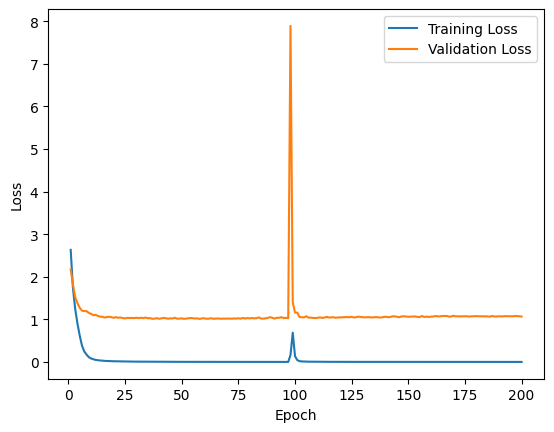

In [6]:
import matplotlib.pyplot as plt
# Instantiate Model
model = MCTestTacNet()
model.to(device)


# Training func
def train_model(model, train_samples, train_labels,val_samples,val_labels,  num_epochs=10, batch_size=32, learning_rate=0.001):
    train_dataset = TensorDataset(train_samples, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    val_dataset = TensorDataset(val_samples, val_labels)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)    
    
    train_samples = train_samples.to(device)
    train_labels = train_labels.to(device)
    
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=170, gamma=0.1)
    
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train(True)
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs) #forward pass
            loss = criterion(outputs, labels) #loss
            loss.backward() #backward pass
            optimizer.step() #update params
            running_loss += loss.item() #calc running loss

        average_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")
        train_losses.append(average_loss)

        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}")
        val_losses.append(val_loss)  # Append validation loss to val_losses

        scheduler.step()

    # Plot training and validation loss
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model, val_loss
    
    print("Training complete!")

#run training
trained_model, val_error = train_model(model, train_samples, train_labels, val_samples, val_labels, num_epochs=200, batch_size=36, learning_rate=0.0001)

# Save the model and validation error
torch.save(trained_model.state_dict(), "trained_model.pth")
with open("val_error.txt", "w") as f:
    f.write(str(val_error))

In [8]:
# Save val_samples
torch.save(test_samples, "test_samples.pth")

# Save val_dataset
torch.save(test_labels, "test_labels.pth")


In [9]:
import sys

# Load Test Data
test_samples = torch.load("test_samples.pth")
test_labels = torch.load("test_labels.pth")

# Define model class if not already defined (assuming MCTestTacNet class is defined as you've provided)
# Instantiate the Model
model = MCTestTacNet()
model.to(device)

# Load the Trained Model
model.load_state_dict(torch.load("trained_model.pth"))

# Function to enable dropout layers during test-time
def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

# Function to get Monte Carlo predictions and uncertainty estimates
def get_monte_carlo_predictions(data_loader, forward_passes, model, n_classes, n_samples):
    """ Function to get the monte-carlo samples and uncertainty estimates through multiple forward passes """
    dropout_predictions = np.empty((0, n_samples, n_classes))
    softmax = nn.Softmax(dim=1)

    for i in range(forward_passes):
        predictions = np.empty((0, n_classes))
        model.eval()
        enable_dropout(model)

        for images, _ in data_loader:
            images = images.to(device)
            with torch.no_grad():
                outputs = model(images)
                outputs = softmax(outputs)
            predictions = np.vstack((predictions, outputs.cpu().numpy()))

        dropout_predictions = np.vstack((dropout_predictions, predictions[np.newaxis, :, :]))

    # Calculate mean across multiple MC Dropout forward passes
    mean = np.mean(dropout_predictions, axis=0)

    # Calculate variance across multiple MC Dropout forward passes
    variance = np.var(dropout_predictions, axis=0)

    epsilon = sys.float_info.min
    # Calculate entropy across multiple MC Dropout forward passes
    entropy = -np.sum(mean * np.log(mean + epsilon), axis=-1)

    # Calculate mutual information across multiple MC Dropout forward passes
    mutual_info = entropy - np.mean(np.sum(-dropout_predictions * np.log(dropout_predictions + epsilon), axis=-1), axis=0)

    return mean, variance, entropy, mutual_info

# Prepare DataLoader for test data
batch_size = 36
test_dataset = TensorDataset(test_samples, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Parameters for Monte Carlo Dropout
forward_passes = 50  # Number of forward passes
n_classes = 36  # Number of classes
n_samples = len(test_samples)  # Number of test samples

# Get Monte Carlo Predictions and Uncertainty Estimates
mean, variance, entropy, mutual_info = get_monte_carlo_predictions(
    test_loader, forward_passes, model, n_classes, n_samples
)

# Print results (or further analyze)
print("Mean Predictions:", mean)
print("Variance Predictions:", variance)
print("Entropy Predictions:", entropy)
print("Mutual Information Predictions:", mutual_info)

/var/tmp/ipykernel_2880/3383654476.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_samples = torch.load("test_samples.pth")
/var/tmp/ipykernel_2880/3383654476.py:5:

Mean Predictions: [[2.39554261e-02 1.73401390e-03 3.18077490e-01 ... 8.47796652e-04
  5.91750827e-04 5.30736637e-04]
 [3.77636099e-02 5.99137667e-02 1.07514846e-02 ... 4.47898435e-04
  1.93029273e-03 6.34859254e-04]
 [9.76898404e-01 1.68613517e-02 9.12100069e-05 ... 6.94288281e-06
  1.34837538e-04 1.22106515e-05]
 ...
 [2.04157585e-05 5.73512606e-06 6.06319670e-07 ... 1.24104429e-06
  1.75837259e-05 9.99717710e-01]
 [3.93400213e-06 1.54621896e-05 4.24636124e-06 ... 8.48827614e-07
  2.73195208e-06 9.99061939e-01]
 [2.20113509e-05 1.12828189e-04 1.15233400e-06 ... 2.38686771e-05
  9.45344799e-04 9.92750691e-01]]
Variance Predictions: [[5.29918885e-04 2.02093658e-06 3.41530813e-02 ... 5.27193051e-07
  1.39077227e-07 1.38769348e-07]
 [9.34896663e-04 4.96287999e-03 2.41020719e-04 ... 2.03671953e-07
  2.17366067e-06 4.34591353e-07]
 [1.78167863e-03 1.23397143e-03 1.59347174e-08 ... 8.79241925e-11
  3.51789124e-08 2.15752490e-10]
 ...
 [4.61657243e-10 4.07724958e-11 6.17988699e-13 ... 9.75310

In [11]:
np.save("mean_predictions.npy", mean)
np.save("variance_predictions.npy", variance)
np.save("entropy_predictions.npy", entropy)
np.save("mutual_info_predictions.npy", mutual_info)

In [9]:
import torch
test_labels = torch.load("test_labels.pth")
test_labels.shape

C:\Users\Memetoglu\AppData\Local\Temp\ipykernel_41936\527977089.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_labels = torch.load("test_labels.pth")


torch.Size([720])

In [22]:
mutual_info.shape

(720,)

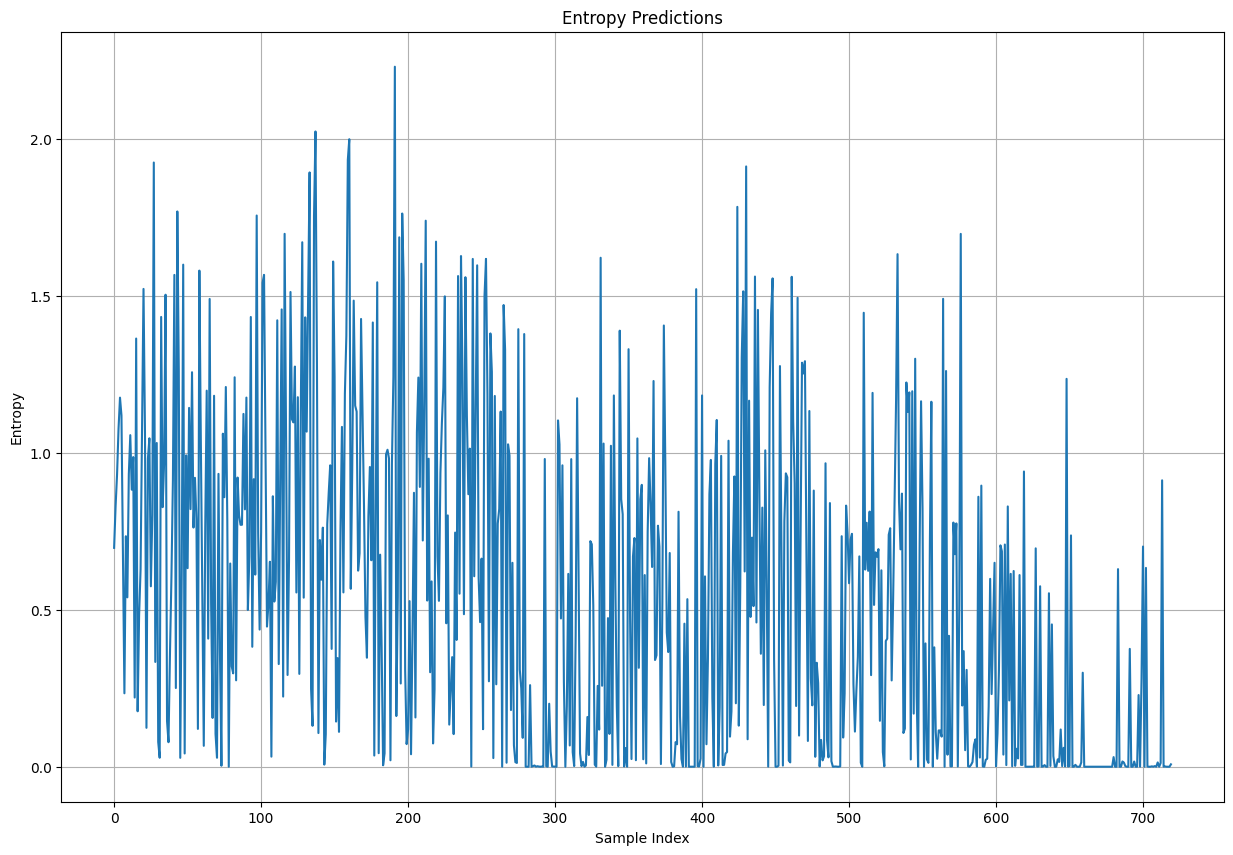

In [23]:
import matplotlib.pyplot as plt
import numpy as np

mean = np.load("mean_predictions.npy")
variance = np.load("variance_predictions.npy")
entropy = np.load("entropy_predictions.npy")
mutual_info = np.load("mutual_info_predictions.npy")


plt.figure(figsize=(15, 10))
plt.plot(entropy)
plt.title("Entropy Predictions")
plt.xlabel("Sample Index")
plt.ylabel("Entropy")
plt.grid(True)
plt.show()

In [10]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Load Test Data
test_samples = torch.load("test_samples.pth")
test_labels = torch.load("test_labels.pth")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model class if not already defined (assuming MCTestTacNet class is defined as you've provided)
# Instantiate the Model
model = MCTestTacNet()
model.to(device)

# Load the Trained Model
model.load_state_dict(torch.load("trained_model.pth"))

# Prepare DataLoader for test data
batch_size = 36
test_dataset = TensorDataset(test_samples, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to calculate accuracy
def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Calculate accuracy on the test data
test_accuracy = calculate_accuracy(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')


/var/tmp/ipykernel_2880/3109515044.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_samples = torch.load("test_samples.pth")
/var/tmp/ipykernel_2880/3109515044.py:7:

Test Accuracy: 68.61%
